# data collection and preperation

In [38]:
from google.colab import files

uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [39]:
import zipfile

with zipfile.ZipFile('archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [40]:
import os

os.listdir('dataset')

['full_archive.npz', 'overview.csv', 'dicom_dir', 'tiff_images']

In [41]:
import pandas as pd

df = pd.read_csv('dataset/overview.csv')
df.head()

,Unnamed: 0,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name
0,0,60,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (1).dcm,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm
1,1,69,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (10).dcm,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm
2,2,74,True,APPLIED,../data/50_50_dicom_cases\Contrast\00001 (11).dcm,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm
3,3,75,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (12).dcm,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm
4,4,56,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (13).dcm,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm


In [43]:
!pip install tifffile

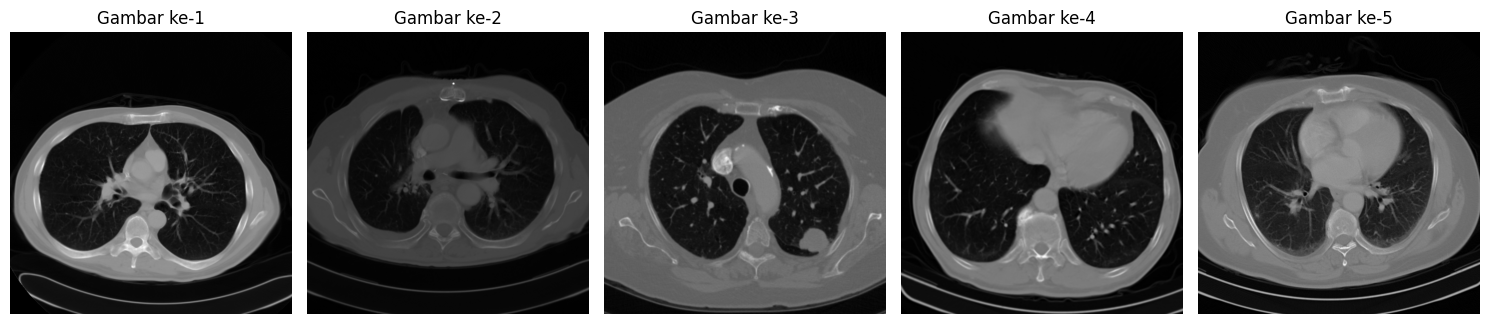

In [44]:
import tifffile as tiff
import matplotlib.pyplot as plt
import os

plt.figure(figsize=(15, 5))

for i in range(5):
    img_path = os.path.join('dataset', 'tiff_images', df['tiff_name'].iloc[i])
    img = tiff.imread(img_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Gambar ke-{i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Data cleaning

In [45]:
df.isnull().sum()

,0
Unnamed: 0,0
Age,0
Contrast,0
ContrastTag,2
raw_input_path,0
id,0
tiff_name,0
dicom_name,0


In [46]:
df.duplicated().sum()

np.int64(0)

In [47]:
df = df.dropna(subset=['ContrastTag'])

In [48]:
df = df.drop(columns=['Unnamed: 0'])

In [49]:
df = df.reset_index(drop=True)

In [50]:
df.isnull().sum()

,0
Age,0
Contrast,0
ContrastTag,0
raw_input_path,0
id,0
tiff_name,0
dicom_name,0


# Feature Enginering

In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['contrast_label'] = le.fit_transform(df['Contrast'])  # hasil: 0 = no contrast, 1 = contrast

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['age_scaled'] = scaler.fit_transform(df[['Age']])

In [53]:
X = df[['age_scaled']]         # fitur input
y = df['contrast_label']       # target klasifikasi

# Machine Learning, training and evaluation

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [56]:
y_pred = model.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred))

Akurasi: 0.65
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.54      0.88      0.67         8
           1       0.86      0.50      0.63        12

    accuracy                           0.65        20
   macro avg       0.70      0.69      0.65        20
weighted avg       0.73      0.65      0.65        20



In [57]:
import numpy as np
from tqdm import tqdm
import tifffile as tiff
import cv2

image_data = []
labels = []

for i in tqdm(range(len(df))):
    path = os.path.join('dataset', 'tiff_images', df['tiff_name'].iloc[i])
    try:
        img = tiff.imread(path)
        img = cv2.resize(img, (150, 150))  # resize to 150x150
        img = img / 255.0  # normalize
        image_data.append(img)
        labels.append(df['Contrast'].iloc[i])  # gunakan label contrast 0 atau 1
    except:
        print(f"Gagal membaca gambar: {path}")

100%|██████████| 98/98 [00:00<00:00, 160.55it/s]


In [58]:
X = np.array(image_data).reshape(-1, 150, 150, 1)
y = np.array(labels)

In [59]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,367,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,460,289 (9.39 MB)

 Trainable params: 2,460,289 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_test, y_test)
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 803ms/step - accuracy: 0.5276 - loss: 2.0014 - val_accuracy: 0.5000 - val_loss: 0.7351
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 744ms/step - accuracy: 0.5666 - loss: 0.6948 - val_accuracy: 0.5000 - val_loss: 0.6876
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 992ms/step - accuracy: 0.6511 - loss: 0.6741 - val_accuracy: 0.6500 - val_loss: 0.6754
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 719ms/step - accuracy: 0.5863 - loss: 0.6526 - val_accuracy: 0.7000 - val_loss: 0.6549
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 741ms/step - accuracy: 0.6293 - loss: 0.6369 - val_accuracy: 0.7000 - val_loss: 0.6108
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7049 - loss: 0.5585 - val_accuracy: 0.7500 - val_loss: 0.5813
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 787ms/step - accuracy: 0.8092 - loss: 0.4880 - val_accuracy: 0.8000 - val_loss: 0.5100
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 691ms/step - accuracy: 0.8074 - loss: 0.4374 - val_accuracy: 0.7500 - val_loss: 0.

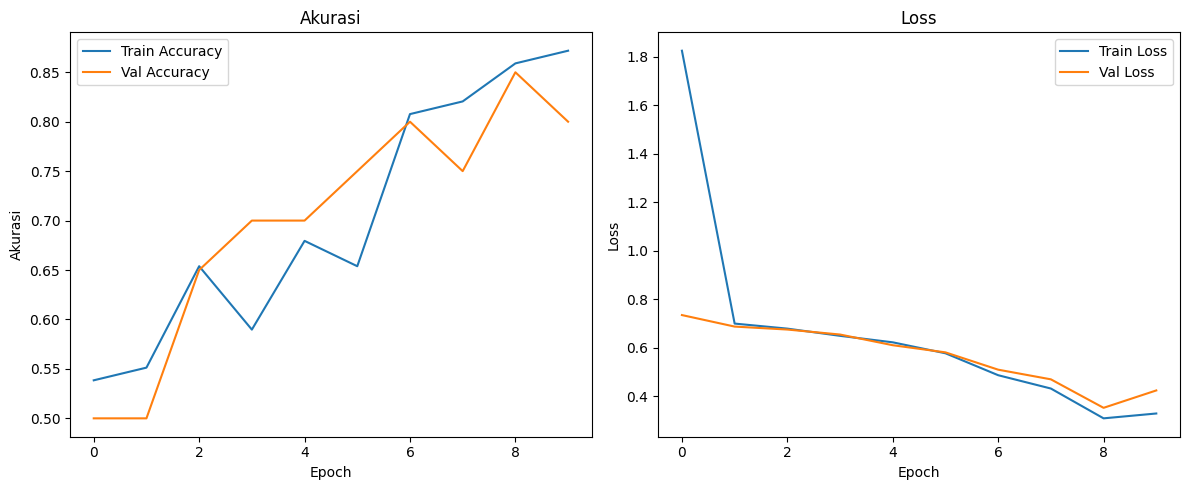

In [62]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

       False       1.00      0.60      0.75        10
        True       0.71      1.00      0.83        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



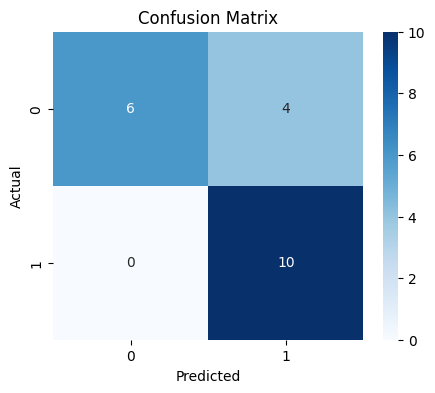

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Prediksi
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [64]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi pada data test: {test_accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8000 - loss: 0.4244
Akurasi pada data test: 0.80


In [65]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Akurasi pada data train: {train_accuracy:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.9367 - loss: 0.2102
Akurasi pada data train: 0.94


In [66]:
model.save('ct_cnn_model.h5')

In [69]:
import os
os.listdir()

['.config',
 'dataset',
 'overview.csv',
 'archive (1).zip',
 'ct_cnn_model.h5',
 'tiff_images.zip',
 'sample_data']

# Visualisation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


<ipython-input-71-8442b2fefccf>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"T:{int(sample_labels[i])} / P:{int(sample_preds[i])}", fontsize=10)


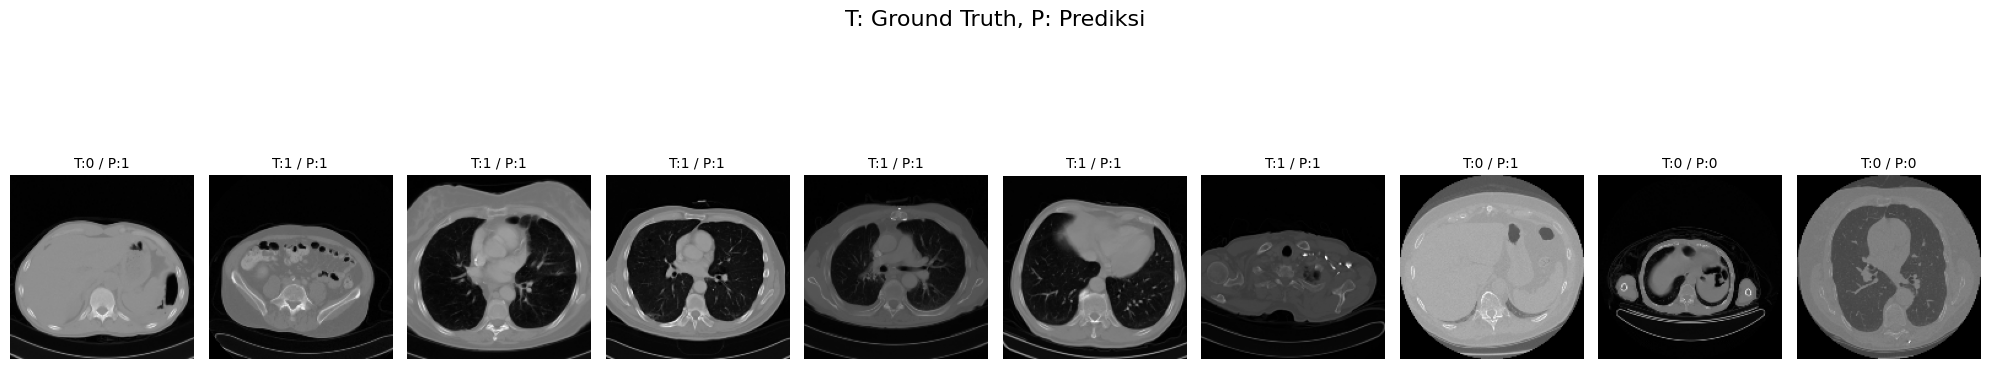

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Pilih 10 sampel random dari X_test
indices = np.random.choice(len(X_test), 10, replace=False)
sample_images = X_test[indices]
sample_labels = y_test[indices]
sample_preds = model.predict(sample_images)
sample_preds = (sample_preds > 0.5).astype(int)

# Visualisasi
plt.figure(figsize=(20, 5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')  # squeeze kalau 2D
    plt.title(f"T:{int(sample_labels[i])} / P:{int(sample_preds[i])}", fontsize=10)
    plt.axis('off')

plt.suptitle("T: Ground Truth, P: Prediksi", fontsize=16)
plt.tight_layout()
plt.show()

# Deploy

In [73]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.0 MB/s eta 0:00:00


In [76]:

!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=76d3946ec801e926ffe3d269dbc6761ee7c458bc0a8a63c4976e87a83f4aa450
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [82]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
from fpdf import FPDF
import uuid
import os

# Load model
model = tf.keras.models.load_model("ct_cnn_model.h5")

# Buat folder untuk menyimpan PDF jika belum ada
os.makedirs("pdf_reports", exist_ok=True)

# Preprocessing function
def preprocess(img):
    img = img.convert("L")  # Grayscale
    img = img.resize((150, 150))
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 150, 150, 1)
    return img_array

# Predict function with PDF generation
def predict_contrast_with_pdf(img):
    img_array = preprocess(img)
    pred = model.predict(img_array)[0][0]
    label = "Dengan Kontras (1)" if pred > 0.5 else "Tanpa Kontras (0)"
    confidence = f"{pred:.2f}"
    result = f"{label} - Confidence: {confidence}"

    # Simpan gambar sementara
    temp_img_path = f"temp_{uuid.uuid4().hex[:6]}.jpg"
    img.save(temp_img_path)

    # Generate PDF
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=16)
    pdf.cell(200, 10, txt="Hasil Prediksi Kontras CT Scan", ln=True, align="C")
    pdf.ln(10)
    pdf.image(temp_img_path, x=30, y=30, w=150)
    pdf.ln(100)
    pdf.set_font("Arial", size=12)
    pdf.ln(100)
    pdf.multi_cell(0, 10, f"Hasil Prediksi: {label}\nConfidence Score: {confidence}")

    # Simpan PDF ke folder
    filename = f"pdf_reports/hasil_prediksi_{uuid.uuid4().hex[:6]}.pdf"
    pdf.output(filename)

    # Hapus gambar sementara
    os.remove(temp_img_path)

    return result, filename

# Gradio Interface
interface = gr.Interface(
    fn=predict_contrast_with_pdf,
    inputs=gr.Image(type="pil"),
    outputs=["text", "file"],
    title="Prediksi Kontras CT Scan",
    description="Upload gambar CT scan. Sistem akan memprediksi apakah menggunakan kontras atau tidak, dan hasilnya dapat diunduh dalam bentuk PDF."
)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c388271fae4e9ba9da.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [80]:

!mkdir -p ctscan-app/pdf_reports

In [81]:
!cp ct_cnn_model.h5 ctscan-app/

In [83]:

code = """
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
from fpdf import FPDF
import uuid
import os

model = tf.keras.models.load_model("ct_cnn_model.h5")
os.makedirs("pdf_reports", exist_ok=True)

def preprocess(img):
    img = img.convert("L")
    img = img.resize((150, 150))
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 150, 150, 1)
    return img_array

def predict_contrast_with_pdf(img):
    img_array = preprocess(img)
    pred = model.predict(img_array)[0][0]
    label = "Dengan Kontras (1)" if pred > 0.5 else "Tanpa Kontras (0)"
    confidence = f"{pred:.2f}"
    result = f"{label} - Confidence: {confidence}"

    temp_img_path = f"temp_{uuid.uuid4().hex[:6]}.jpg"
    img.save(temp_img_path)

    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=16)
    pdf.cell(200, 10, txt="Hasil Prediksi Kontras CT Scan", ln=True, align="C")
    pdf.ln(10)
    pdf.image(temp_img_path, x=30, y=30, w=150)
    pdf.ln(100)
    pdf.set_font("Arial", size=12)
    pdf.ln(100)
    pdf.multi_cell(0, 10, f"Hasil Prediksi: {label}\\nConfidence Score: {confidence}")

    filename = f"pdf_reports/hasil_prediksi_{uuid.uuid4().hex[:6]}.pdf"
    pdf.output(filename)

    os.remove(temp_img_path)

    return result, filename

interface = gr.Interface(
    fn=predict_contrast_with_pdf,
    inputs=gr.Image(type="pil"),
    outputs=["text", "file"],
    title="Prediksi Kontras CT Scan",
    description="Upload gambar CT scan. Sistem akan memprediksi apakah menggunakan kontras atau tidak, dan hasilnya dapat diunduh dalam bentuk PDF."
)

interface.launch()
"""

with open("ctscan-app/app.py", "w") as f:
    f.write(code)

In [84]:
reqs = """
gradio
tensorflow
Pillow
fpdf
numpy
"""

with open("ctscan-app/requirements.txt", "w") as f:
    f.write(reqs)

In [85]:
!zip -r ctscan-app.zip ctscan-app

  adding: ctscan-app/ (stored 0%)
  adding: ctscan-app/requirements.txt (deflated 3%)
  adding: ctscan-app/ct_cnn_model.h5 (deflated 19%)
  adding: ctscan-app/app.py (deflated 53%)
  adding: ctscan-app/pdf_reports/ (stored 0%)
